In [1]:
# class for easy training
import torch
from exp.exp_main import Exp_Main
from collections import namedtuple
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from hyperopt import fmin, tpe, Trials, STATUS_OK, hp
import torch
import pickle


class Train_Tester:
    """
    Train_Tester: Manages initialisation, training, validation, and visualisation for Preformer models.

    Methods:
    - _plot(trues, preds): Internal method to plot true vs predicted values.
    - _set_args(): Set the arguments for training, validation, and testing.
    - train(): Configures the model parameters and trains the Preformer model.
    - validate(model): Validates the trained model and calculates error metrics.
    - test(model): Sets up and conducts testing for the model, evaluates performance, and visualieses predictions.

    Note: Attributes are to the ones same available at ./run_longExp.py
    """
    def __init__(self, **kwargs):

        self.is_training = kwargs.get('is_training', 1)
        self.train_only = kwargs.get('train_only', False)
        self.model_id = kwargs.get('model_id', 'test')
        self.model = kwargs.get('model', 'Autoformer')
        self.saved_model_path = kwargs.get('saved_model_path', None)

        self.data = kwargs.get('data', 'ETTm1')
        self.root_path = kwargs.get('root_path', './data/ETT/')
        self.data_path = kwargs.get('data_path', 'ETTh1.csv')
        self.features = kwargs.get('features', 'M')
        self.target = kwargs.get('target', 'close')
        self.freq = kwargs.get('freq', 'h')
        self.checkpoints = kwargs.get('checkpoints', './checkpoints/')

        self.seq_len = kwargs.get('seq_len', 96)
        self.label_len = kwargs.get('label_len', 48)
        self.pred_len = kwargs.get('pred_len', 96)

        self.individual = kwargs.get('individual', False)
        self.embed_type = kwargs.get('embed_type', 0)
        self.enc_in = kwargs.get('enc_in', 7)
        self.dec_in = kwargs.get('dec_in', 7)
        self.c_out = kwargs.get('c_out', 7)
        self.d_model = kwargs.get('d_model', 512)
        self.n_heads = kwargs.get('n_heads', 8)
        self.e_layers = kwargs.get('e_layers', 2)
        self.d_layers = kwargs.get('d_layers', 1)
        self.d_ff = kwargs.get('d_ff', 2048)
        self.moving_avg = kwargs.get('moving_avg', 25)
        self.factor = kwargs.get('factor', 1)
        self.distil = kwargs.get('distil', True)
        self.dropout = kwargs.get('dropout', 0.05)
        self.embed = kwargs.get('embed', 'timeF')
        self.activation = kwargs.get('activation', 'gelu')
        self.output_attention = kwargs.get('output_attention', False)
        self.do_predict = kwargs.get('do_predict', False)
        self.do_custom_predict = kwargs.get('do_custom_predict', False)

        self.num_workers = kwargs.get('num_workers', 10)
        self.itr = kwargs.get('itr', 2)
        self.train_epochs = kwargs.get('train_epochs', 10)
        self.batch_size = kwargs.get('batch_size', 32)
        self.patience = kwargs.get('patience', 3)
        self.learning_rate = kwargs.get('learning_rate', 0.0001)
        self.des = kwargs.get('des', 'test')
        self.loss = kwargs.get('loss', 'mse')
        self.lradj = kwargs.get('lradj', 'type1')
        self.use_amp = kwargs.get('use_amp', False)

        self.use_gpu = kwargs.get('use_gpu', True)
        self.gpu = kwargs.get('gpu', 0)
        self.use_multi_gpu = kwargs.get('use_multi_gpu', False)
        self.devices = kwargs.get('devices', '0,1,2,3')
        self.test_flop = kwargs.get('test_flop', False)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.exp = Exp_Main

    def _plot(self, trues, preds):
        preds = preds[::self.pred_len]
        trues = trues[::self.pred_len]
        plt.figure(figsize=(12,6))
        plt.plot(trues, label='True', linewidth=0.5)
        plt.plot(preds, label='Predicted', linewidth=0.5)
        plt.title("Model Per. on Test Set")
        plt.legend()
        plt.show()

    def _set_args(self):
        Args = namedtuple('Args', ['is_training', 'train_only', 'model_id', 'model', 'saved_model_path',
                        'data', 'root_path', 'data_path', 'features', 'target', 'freq', 'checkpoints',
                        'seq_len', 'label_len', 'pred_len', 'individual', 'embed_type', 'enc_in',
                        'dec_in', 'c_out', 'd_model', 'n_heads', 'e_layers', 'd_layers', 'd_ff',
                        'moving_avg', 'factor', 'distil', 'dropout', 'embed', 'activation',
                        'output_attention', 'do_predict', 'do_custom_predict', 'num_workers', 'itr',
                        'train_epochs', 'batch_size', 'patience', 'learning_rate', 'des', 'loss',
                        'lradj', 'use_amp', 'use_gpu', 'gpu', 'use_multi_gpu', 'devices', 'test_flop'])

        self.args = Args(is_training=self.is_training, train_only=self.train_only, model_id=self.model_id,
                    model=self.model, saved_model_path=self.saved_model_path, data=self.data,
                    root_path=self.root_path, data_path=self.data_path, features=self.features,
                    target=self.target, freq=self.freq, checkpoints=self.checkpoints, seq_len=self.seq_len,
                    label_len=self.label_len, pred_len=self.pred_len, individual=self.individual,
                    embed_type=self.embed_type, enc_in=self.enc_in, dec_in=self.dec_in, c_out=self.c_out,
                    d_model=self.d_model, n_heads=self.n_heads, e_layers=self.e_layers, d_layers=self.d_layers,
                    d_ff=self.d_ff, moving_avg=self.moving_avg, factor=self.factor, distil=self.distil,
                    dropout=self.dropout, embed=self.embed, activation=self.activation,
                    output_attention=self.output_attention, do_predict=self.do_predict,
                    do_custom_predict=self.do_custom_predict, num_workers=self.num_workers, itr=self.itr,
                    train_epochs=self.train_epochs, batch_size=self.batch_size, patience=self.patience,
                    learning_rate=self.learning_rate, des=self.des, loss=self.loss, lradj=self.lradj,
                    use_amp=self.use_amp, use_gpu=self.use_gpu, gpu=self.gpu, use_multi_gpu=self.use_multi_gpu,
                    devices=self.devices, test_flop=self.test_flop)


        self.exp = Exp_Main(self.args)

    def train(self):
        self._set_args()
        for ii in range(self.itr):
            # setting record of experiments
            setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
                self.model_id,
                self.model,
                self.data,
                self.features,
                self.seq_len,
                self.label_len,
                self.pred_len,
                self.d_model,
                self.n_heads,
                self.e_layers,
                self.d_layers,
                self.d_ff,
                self.factor,
                self.embed,
                self.distil,
                self.des, ii)

            print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
            self.exp.train(setting)
            torch.cuda.empty_cache()
        return self.exp.train(setting)
    
    def validate(self, model):
        self._set_args()
        preds, trues, mse, mae = self.exp.custom_predict(model, load_saved=False)
        return mse, mae

    def test(self, model):
        self._set_args()
        preds, trues, mse, mae = self.exp.custom_predict(model, load_saved=False)
        print(f'MSE: {mse} MAE: {mae}')
        preds = preds[:, -1].reshape(-1, 1)
        trues = trues[:, -1].reshape(-1, 1)
        self._plot(trues, preds)
        return preds, trues, mse, mae
    
torch.cuda.set_device(3)  

# Preformer Model Testing

## Close Col Only

#### Close Column Only (Input: last 12 data points, Output: the next first future data)

Use GPU: cuda:3
>>>>>>>start training : preformer_btc_12_1_1_close_only_Preformer_custom_ftMS_sl12_ll1_pl1_dm512_nh8_el2_dl1_df1024_fc1_ebtimeF_dtTrue_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 89801
	iters: 100, epoch: 1 | loss: 0.0153372
	speed: 0.0401s/iter; left time: 52.2312s
	iters: 200, epoch: 1 | loss: 0.0057639
	speed: 0.0341s/iter; left time: 41.0369s
	iters: 300, epoch: 1 | loss: 0.0025331
	speed: 0.0342s/iter; left time: 37.7799s
	iters: 400, epoch: 1 | loss: 0.0019698
	speed: 0.0339s/iter; left time: 34.0095s
	iters: 500, epoch: 1 | loss: 0.0013195
	speed: 0.0344s/iter; left time: 31.1355s
	iters: 600, epoch: 1 | loss: 0.0012342
	speed: 0.0340s/iter; left time: 27.3718s
	iters: 700, epoch: 1 | loss: 0.0008328
	speed: 0.0315s/iter; left time: 22.1418s
	iters: 800, epoch: 1 | loss: 0.0007695
	speed: 0.0308s/iter; left time: 18.6152s
	iters: 900, epoch: 1 | loss: 0.0008196
	speed: 0.0305s/iter; left time: 15.3652s
	iters: 1000, epoch: 1 | loss: 0.0002466
	speed: 0.0306s/iter; lef

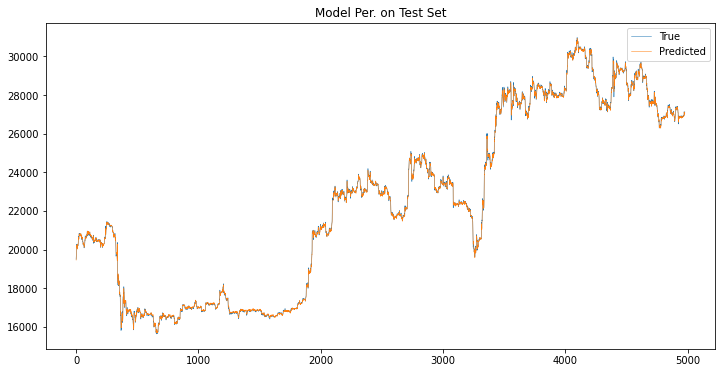

(array([[19455.518],
        [19706.553],
        [19784.193],
        ...,
        [27052.17 ],
        [27040.543],
        [27037.107]], dtype=float32),
 array([[19496.],
        [19741.],
        [19819.],
        ...,
        [27045.],
        [27077.],
        [27115.]], dtype=float32),
 1916.3784,
 34.44004)

In [2]:
args_dict_train = {
            "is_training": 1,
            "train_only": True,
            "model_id": "preformer_btc_12_1_1_close_only",
            "model": "Preformer",
            "data": "custom",
            "root_path": "../../../data/",
            "data_path": "training_data_close_col_only_for_other_models.csv",
            "features": "MS",
            "target": "close",
            "freq": "h",
            "seq_len": 12,
            "label_len": 1,
            "pred_len": 1,
            "enc_in": 1,
            "dec_in": 1,
            "c_out": 1,
            "d_model": 512,
            "n_heads": 8,
            "e_layers": 2,
            "d_layers": 1,
            "d_ff": 1024,
            "dropout": 0.28,
            "embed": "timeF",
            "activation": "gelu",
            "do_predict": True,
            "train_epochs": 50,
            "batch_size": 64,
            "learning_rate": 0.001,
            "loss": "mse",
            "use_gpu": 1,
            "gpu": 3,
            "train_epochs": 1
        }

model = Train_Tester(**args_dict_train).train()
args_dict_val = {

    
    "root_path": "../../../data/",
    "data_path": "testing_data_close_col_only_for_other_models.csv",
    "model_id": "preformer_btc_12_1_1_close_only",
    "model": "Preformer",
    "data": "custom",
    "features": "MS",
    "target": "close",
    "freq": "h",
    "seq_len": 12,
    "label_len": 1,
    "pred_len": 1,
    "enc_in": 1,
    "dec_in": 1,
    "c_out": 1,
    "d_model": 512,
    "n_heads": 8,
    "e_layers": 2,
    "d_layers": 1,
    "d_ff": 1024,
    "dropout": 0.28,
    "embed": "timeF",
    "activation": "gelu",
    "do_predict": True,
    "use_gpu": 1,
    "gpu": 3,
    "batch_size": 1,
}

Train_Tester(**args_dict_val).test(model)


#### Close Column Only (Input: last 12 data points, Output: the next 12th future data)

Use GPU: cuda:3
>>>>>>>start training : preformer_btc_12_12_12_close_only_Preformer_custom_ftMS_sl12_ll12_pl12_dm512_nh8_el2_dl1_df1024_fc1_ebtimeF_dtTrue_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 89790
	iters: 100, epoch: 1 | loss: 0.0097337
	speed: 0.5399s/iter; left time: 703.5230s
	iters: 200, epoch: 1 | loss: 0.0048278
	speed: 0.4940s/iter; left time: 594.2902s
	iters: 300, epoch: 1 | loss: 0.0054598
	speed: 0.4923s/iter; left time: 543.0106s
	iters: 400, epoch: 1 | loss: 0.0030836
	speed: 0.4852s/iter; left time: 486.6436s
	iters: 500, epoch: 1 | loss: 0.0026620
	speed: 0.4648s/iter; left time: 419.7097s
	iters: 600, epoch: 1 | loss: 0.0018862
	speed: 0.4662s/iter; left time: 374.3192s
	iters: 700, epoch: 1 | loss: 0.0018015
	speed: 0.4626s/iter; left time: 325.2138s
	iters: 800, epoch: 1 | loss: 0.0020177
	speed: 0.4807s/iter; left time: 289.8431s
	iters: 900, epoch: 1 | loss: 0.0010564
	speed: 0.4599s/iter; left time: 231.3445s
	iters: 1000, epoch: 1 | loss: 0.0016717
	speed: 0.48

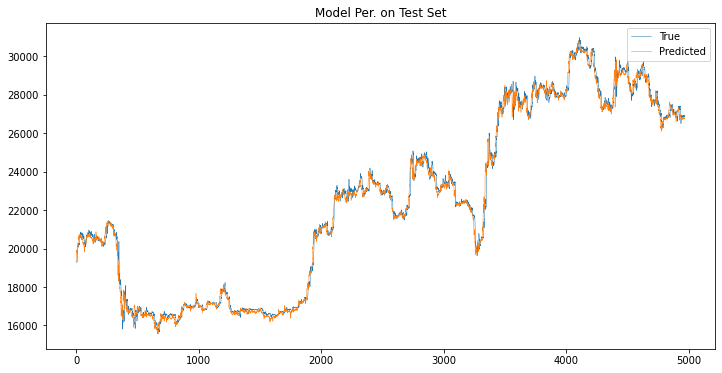

(array([[19352.072],
        [19320.08 ],
        [19324.438],
        ...,
        [26785.76 ],
        [26788.643],
        [26837.873]], dtype=float32),
 array([[19344.],
        [19341.],
        [19336.],
        ...,
        [26899.],
        [26891.],
        [26905.]], dtype=float32),
 62179.22,
 164.0212)

In [3]:
args_dict_train = {
            "is_training": 1,
            "train_only": True,
            "model_id": "preformer_btc_12_12_12_close_only",
            "model": "Preformer",
            "data": "custom",
            "root_path": "../../../data/",
            "data_path": "training_data_close_col_only_for_other_models.csv",
            "features": "MS",
            "target": "close",
            "freq": "h",
            "seq_len": 12,
            "label_len": 12,
            "pred_len": 12,
            "enc_in": 1,
            "dec_in": 1,
            "c_out": 1,
            "d_model": 512,
            "n_heads": 8,
            "e_layers": 2,
            "d_layers": 1,
            "d_ff": 1024,
            "dropout": 0.28,
            "embed": "timeF",
            "activation": "gelu",
            "do_predict": True,
            "train_epochs": 50,
            "batch_size": 64,
            "learning_rate": 0.001,
            "loss": "mse",
            "use_gpu": 1,
            "gpu": 3,
            "train_epochs": 1
        }

model = Train_Tester(**args_dict_train).train()
args_dict_val = {
    "root_path": "../../../data/",
    "data_path": "testing_data_close_col_only_for_other_models.csv",
    "model_id": "preformer_btc_12_12_12_close_only",
    "model": "Preformer",
    "data": "custom",
    "features": "MS",
    "target": "close",
    "freq": "h",
    "seq_len": 12,
    "label_len": 12,
    "pred_len": 12,
    "enc_in": 1,
    "dec_in": 1,
    "c_out": 1,
    "d_model": 512,
    "n_heads": 8,
    "e_layers": 2,
    "d_layers": 1,
    "d_ff": 1024,
    "dropout": 0.28,
    "embed": "timeF",
    "activation": "gelu",
    "do_predict": True,
    "use_gpu": 1,
    "gpu": 3,
    "batch_size": 1,
}

Train_Tester(**args_dict_val).test(model)


#### Close Column Only (Input: last 96 data points, Output: the next first future data)

Use GPU: cuda:3
>>>>>>>start training : preformer_btc_96_1_1_close_only_Preformer_custom_ftMS_sl96_ll1_pl1_dm512_nh8_el2_dl1_df1024_fc1_ebtimeF_dtTrue_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 89717
	iters: 100, epoch: 1 | loss: 0.0220502
	speed: 0.5134s/iter; left time: 668.3974s
	iters: 200, epoch: 1 | loss: 0.0051557
	speed: 0.4684s/iter; left time: 563.0070s
	iters: 300, epoch: 1 | loss: 0.0051866
	speed: 0.4885s/iter; left time: 538.2864s
	iters: 400, epoch: 1 | loss: 0.0024803
	speed: 0.4547s/iter; left time: 455.6262s
	iters: 500, epoch: 1 | loss: 0.0029095
	speed: 0.4788s/iter; left time: 431.8938s
	iters: 600, epoch: 1 | loss: 0.0053477
	speed: 0.4772s/iter; left time: 382.7500s
	iters: 700, epoch: 1 | loss: 0.0029521
	speed: 0.5065s/iter; left time: 355.5688s
	iters: 800, epoch: 1 | loss: 0.0029837
	speed: 0.4956s/iter; left time: 298.3485s
	iters: 900, epoch: 1 | loss: 0.0040357
	speed: 0.4555s/iter; left time: 228.6777s
	iters: 1000, epoch: 1 | loss: 0.0039376
	speed: 0.4610s/

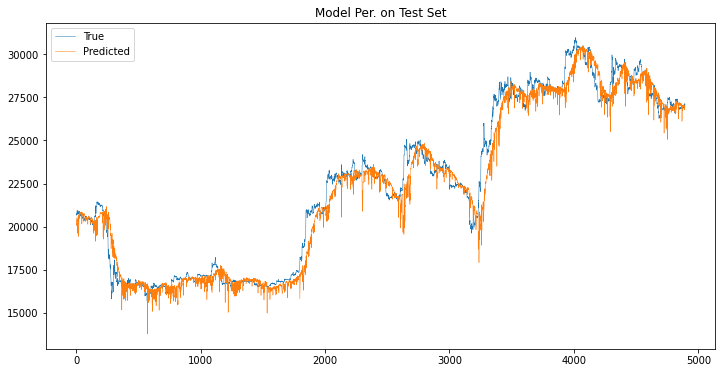

(array([[20060.953],
        [20262.816],
        [20350.12 ],
        ...,
        [26832.844],
        [26956.488],
        [27094.703]], dtype=float32),
 array([[20746.],
        [20762.],
        [20685.],
        ...,
        [27045.],
        [27077.],
        [27115.]], dtype=float32),
 787082.8,
 583.6127)

In [4]:
args_dict_train = {
            "is_training": 1,
            "train_only": True,
            "model_id": "preformer_btc_96_1_1_close_only",
            "model": "Preformer",
            "data": "custom",
            "root_path": "../../../data/",
            "data_path": "training_data_close_col_only_for_other_models.csv",
            "features": "MS",
            "target": "close",
            "freq": "h",
            "seq_len": 96,
            "label_len": 1,
            "pred_len": 1,
            "enc_in": 1,
            "dec_in": 1,
            "c_out": 1,
            "d_model": 512,
            "n_heads": 8,
            "e_layers": 2,
            "d_layers": 1,
            "d_ff": 1024,
            "dropout": 0.28,
            "embed": "timeF",
            "activation": "gelu",
            "do_predict": True,
            "train_epochs": 50,
            "batch_size": 64,
            "learning_rate": 0.001,
            "loss": "mse",
            "use_gpu": 1,
            "gpu": 3,
            "train_epochs": 1
        }

model = Train_Tester(**args_dict_train).train()
args_dict_val = {
    "root_path": "../../../data/",
    "data_path": "testing_data_close_col_only_for_other_models.csv",
    "model_id": "preformer_btc_96_1_1_close_only",
    "model": "Preformer",
    "data": "custom",
    "features": "MS",
    "target": "close",
    "freq": "h",
    "seq_len": 96,
    "label_len": 1,
    "pred_len": 1,
    "enc_in": 1,
    "dec_in": 1,
    "c_out": 1,
    "d_model": 512,
    "n_heads": 8,
    "e_layers": 2,
    "d_layers": 1,
    "d_ff": 1024,
    "dropout": 0.28,
    "embed": "timeF",
    "activation": "gelu",
    "do_predict": True,
    "use_gpu": 1,
    "gpu": 3,
    "batch_size": 1,
}

Train_Tester(**args_dict_val).test(model)


#### Close Column Only (Input: last 96 data points, Output: the next 12th future data) 

Use GPU: cuda:3
>>>>>>>start training : preformer_btc_96_12_12_close_only_Preformer_custom_ftMS_sl96_ll12_pl12_dm512_nh8_el2_dl1_df1024_fc1_ebtimeF_dtTrue_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 89706
	iters: 100, epoch: 1 | loss: 0.0123969
	speed: 0.1669s/iter; left time: 217.3476s
	iters: 200, epoch: 1 | loss: 0.0058747
	speed: 0.1442s/iter; left time: 173.2752s
	iters: 300, epoch: 1 | loss: 0.0055878
	speed: 0.1456s/iter; left time: 160.4345s
	iters: 400, epoch: 1 | loss: 0.0032689
	speed: 0.1511s/iter; left time: 151.4063s
	iters: 500, epoch: 1 | loss: 0.0020705
	speed: 0.1468s/iter; left time: 132.4170s
	iters: 600, epoch: 1 | loss: 0.0035628
	speed: 0.1566s/iter; left time: 125.5945s
	iters: 700, epoch: 1 | loss: 0.0049977
	speed: 0.1441s/iter; left time: 101.1560s
	iters: 800, epoch: 1 | loss: 0.0038044
	speed: 0.1445s/iter; left time: 87.0024s
	iters: 900, epoch: 1 | loss: 0.0019096
	speed: 0.1446s/iter; left time: 72.5992s
	iters: 1000, epoch: 1 | loss: 0.0059028
	speed: 0.1445

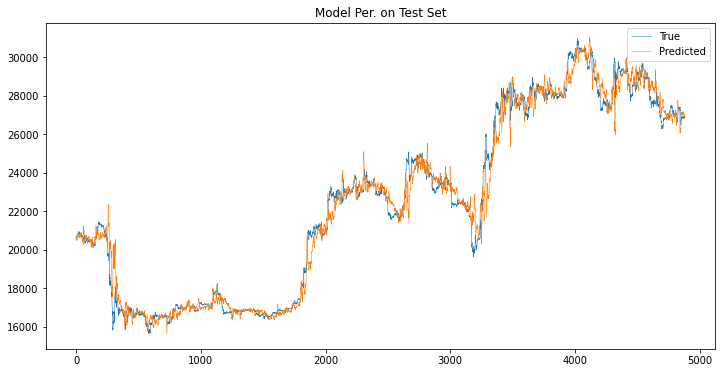

(array([[20672.697],
        [20737.05 ],
        [20556.531],
        ...,
        [26960.676],
        [27052.23 ],
        [27045.723]], dtype=float32),
 array([[20479.],
        [20712.],
        [20634.],
        ...,
        [26899.],
        [26891.],
        [26905.]], dtype=float32),
 414962.4,
 420.88367)

In [5]:
args_dict_train = {
            "is_training": 1,
            "train_only": True,
            "model_id": "preformer_btc_96_12_12_close_only",
            "model": "Preformer",
            "data": "custom",
            "root_path": "../../../data/",
            "data_path": "training_data_close_col_only_for_other_models.csv",
            "features": "MS",
            "target": "close",
            "freq": "h",
            "seq_len": 96,
            "label_len": 12,
            "pred_len": 12,
            "enc_in": 1,
            "dec_in": 1,
            "c_out": 1,
            "d_model": 512,
            "n_heads": 8,
            "e_layers": 2,
            "d_layers": 1,
            "d_ff": 1024,
            "dropout": 0.28,
            "embed": "timeF",
            "activation": "gelu",
            "do_predict": True,
            "train_epochs": 50,
            "batch_size": 64,
            "learning_rate": 0.001,
            "loss": "mse",
            "use_gpu": 1,
            "gpu": 3,
            "train_epochs": 1
        }

model = Train_Tester(**args_dict_train).train()
args_dict_val = {
    "root_path": "../../../data/",
    "data_path": "testing_data_close_col_only_for_other_models.csv",
    "model_id": "preformer_btc_96_12_12_close_only",
    "model": "Preformer",
    "data": "custom",
    "features": "MS",
    "target": "close",
    "freq": "h",
    "seq_len": 96,
    "label_len": 12,
    "pred_len": 12,
    "enc_in": 1,
    "dec_in": 1,
    "c_out": 1,
    "d_model": 512,
    "n_heads": 8,
    "e_layers": 2,
    "d_layers": 1,
    "d_ff": 1024,
    "dropout": 0.28,
    "embed": "timeF",
    "activation": "gelu",
    "do_predict": True,
    "use_gpu": 1,
    "gpu": 3,
    "batch_size": 1,
}

Train_Tester(**args_dict_val).test(model)


#### Close Column Only (Input: last 504 data points (1 week), Output: the next 12th future data)

In [6]:
args_dict_train = {
            "is_training": 1,
            "train_only": True,
            "model_id": "preformer_btc_504_12_12_close_only",
            "model": "Preformer",
            "data": "custom",
            "root_path": "../../../data/",
            "data_path": "training_data_close_col_only_for_other_models.csv",
            "features": "MS",
            "target": "close",
            "freq": "h",
            "seq_len": 504,
            "label_len": 12,
            "pred_len": 12,
            "enc_in": 1,
            "dec_in": 1,
            "c_out": 1,
            "d_model": 512,
            "n_heads": 8,
            "e_layers": 2,
            "d_layers": 1,
            "d_ff": 1024,
            "dropout": 0.28,
            "embed": "timeF",
            "activation": "gelu",
            "do_predict": True,
            "train_epochs": 50,
            "batch_size": 64,
            "learning_rate": 0.001,
            "loss": "mse",
            "use_gpu": 1,
            "gpu": 3,
            "train_epochs": 1
        }

model = Train_Tester(**args_dict_train).train()
args_dict_val = {
    "root_path": "../../../data/",
    "data_path": "testing_data_close_col_only_for_other_models.csv",
    "model_id": "preformer_btc_504_12_12_close_only",
    "model": "Preformer",
    "data": "custom",
    "features": "MS",
    "target": "close",
    "freq": "h",
    "seq_len": 504,
    "label_len": 12,
    "pred_len": 12,
    "enc_in": 1,
    "dec_in": 1,
    "c_out": 1,
    "d_model": 512,
    "n_heads": 8,
    "e_layers": 2,
    "d_layers": 1,
    "d_ff": 1024,
    "dropout": 0.28,
    "embed": "timeF",
    "activation": "gelu",
    "do_predict": True,
    "use_gpu": 1,
    "gpu": 3,
    "batch_size": 1,
}

Train_Tester(**args_dict_val).test(model)


Use GPU: cuda:3
>>>>>>>start training : preformer_btc_504_12_12_close_only_Preformer_custom_ftMS_sl504_ll12_pl12_dm512_nh8_el2_dl1_df1024_fc1_ebtimeF_dtTrue_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 89298


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 3; 7.79 GiB total capacity; 6.25 GiB already allocated; 52.50 MiB free; 6.67 GiB reserved in total by PyTorch)

## Top Columns 

#### Top Columns (Input: last 12 data points, Output: the next first future data)

Use GPU: cuda:3
>>>>>>>start training : preformer_btc_12_1_1_top_features_Preformer_custom_ftMS_sl12_ll1_pl1_dm512_nh8_el2_dl1_df1024_fc1_ebtimeF_dtTrue_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 89801
	iters: 100, epoch: 1 | loss: 0.0092660
	speed: 0.2912s/iter; left time: 379.7492s
	iters: 200, epoch: 1 | loss: 0.0030586
	speed: 0.3028s/iter; left time: 364.5224s
	iters: 300, epoch: 1 | loss: 0.0039021
	speed: 0.2755s/iter; left time: 304.1375s
	iters: 400, epoch: 1 | loss: 0.0020905
	speed: 0.2904s/iter; left time: 291.5537s
	iters: 500, epoch: 1 | loss: 0.0019466
	speed: 0.2754s/iter; left time: 248.9492s
	iters: 600, epoch: 1 | loss: 0.0014421
	speed: 0.3135s/iter; left time: 252.0873s
	iters: 700, epoch: 1 | loss: 0.0008977
	speed: 0.2808s/iter; left time: 197.6773s
	iters: 800, epoch: 1 | loss: 0.0008518
	speed: 0.2617s/iter; left time: 158.0367s
	iters: 900, epoch: 1 | loss: 0.0005693
	speed: 0.2891s/iter; left time: 145.6853s
	iters: 1000, epoch: 1 | loss: 0.0007777
	speed: 0.2560

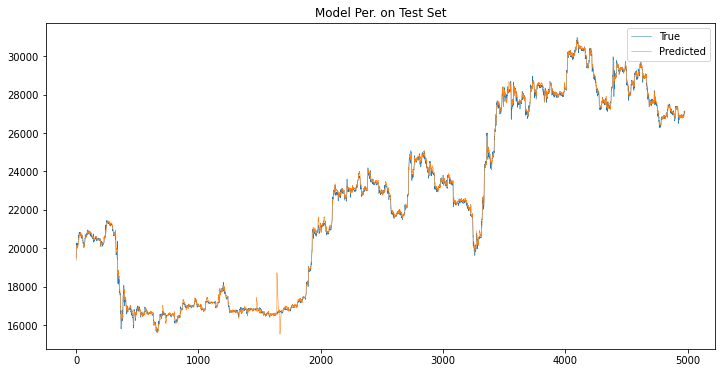

(array([[19362.656],
        [19500.773],
        [19631.57 ],
        ...,
        [27003.184],
        [27054.686],
        [27170.336]], dtype=float32),
 array([[19496.],
        [19741.],
        [19819.],
        ...,
        [27045.],
        [27077.],
        [27115.]], dtype=float32),
 21806.992,
 104.71424)

In [3]:
args_dict_train = {
            "is_training": 1,
            "train_only": True,
            "model_id": "preformer_btc_12_1_1_top_features",
            "model": "Preformer",
            "data": "custom",
            "root_path": "../../../data/",
            "data_path": "training_data_top_features_for_other_models.csv",
            "features": "MS",
            "target": "close",
            "freq": "h",
            "seq_len": 12,
            "label_len": 1,
            "pred_len": 1,
            "enc_in": 11,
            "dec_in": 11,
            "c_out": 1,
            "d_model": 512,
            "n_heads": 8,
            "e_layers": 2,
            "d_layers": 1,
            "d_ff": 1024,
            "dropout": 0.28,
            "embed": "timeF",
            "activation": "gelu",
            "do_predict": True,
            "train_epochs": 50,
            "batch_size": 64,
            "learning_rate": 0.001,
            "loss": "mse",
            "use_gpu": 1,
            "gpu": 3,
            "train_epochs": 1
        }

model = Train_Tester(**args_dict_train).train()
args_dict_val = {
    "root_path": "../../../data/",
    "data_path": "testing_data_top_features_for_other_models.csv",
    "model_id": "preformer_btc_12_1_1_top_features",
    "model": "Preformer",
    "data": "custom",
    "features": "MS",
    "target": "close",
    "freq": "h",
    "seq_len": 12,
    "label_len": 1,
    "pred_len": 1,
    "enc_in": 11,
    "dec_in": 11,
    "c_out": 1,
    "d_model": 512,
    "n_heads": 8,
    "e_layers": 2,
    "d_layers": 1,
    "d_ff": 1024,
    "dropout": 0.28,
    "embed": "timeF",
    "activation": "gelu",
    "do_predict": True,
    "use_gpu": 1,
    "gpu": 3,
    "batch_size": 1,
}

Train_Tester(**args_dict_val).test(model)


#### Top Columns (Input: last 12 data points, Output: the next 12th future data)

Use GPU: cuda:3
>>>>>>>start training : preformer_btc_12_12_12_top_features_Preformer_custom_ftMS_sl12_ll12_pl12_dm512_nh8_el2_dl1_df1024_fc1_ebtimeF_dtTrue_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 89790
	iters: 100, epoch: 1 | loss: 0.0092103
	speed: 0.3588s/iter; left time: 467.5152s
	iters: 200, epoch: 1 | loss: 0.0063989
	speed: 0.3587s/iter; left time: 431.4782s
	iters: 300, epoch: 1 | loss: 0.0048670
	speed: 0.3425s/iter; left time: 377.7616s
	iters: 400, epoch: 1 | loss: 0.0023710
	speed: 0.3255s/iter; left time: 326.4906s
	iters: 500, epoch: 1 | loss: 0.0015893
	speed: 0.3039s/iter; left time: 274.4401s
	iters: 600, epoch: 1 | loss: 0.0009778
	speed: 0.3454s/iter; left time: 277.3531s
	iters: 700, epoch: 1 | loss: 0.0016658
	speed: 0.3393s/iter; left time: 238.5081s
	iters: 800, epoch: 1 | loss: 0.0010677
	speed: 0.3561s/iter; left time: 214.7570s
	iters: 900, epoch: 1 | loss: 0.0014094
	speed: 0.3503s/iter; left time: 176.1918s
	iters: 1000, epoch: 1 | loss: 0.0007756
	speed: 0.

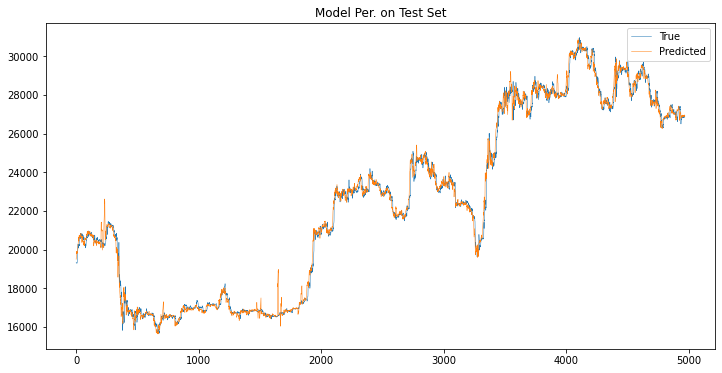

(array([[19494.412],
        [19407.748],
        [19399.89 ],
        ...,
        [26952.744],
        [26941.518],
        [26945.895]], dtype=float32),
 array([[19344.],
        [19341.],
        [19336.],
        ...,
        [26899.],
        [26891.],
        [26905.]], dtype=float32),
 77326.34,
 165.85294)

In [4]:
args_dict_train = {
            "is_training": 1,
            "train_only": True,
            "model_id": "preformer_btc_12_12_12_top_features",
            "model": "Preformer",
            "data": "custom",
            "root_path": "../../../data/",
            "data_path": "training_data_top_features_for_other_models.csv",
            "features": "MS",
            "target": "close",
            "freq": "h",
            "seq_len": 12,
            "label_len": 12,
            "pred_len": 12,
            "enc_in": 11,
            "dec_in": 11,
            "c_out": 1,
            "d_model": 512,
            "n_heads": 8,
            "e_layers": 2,
            "d_layers": 1,
            "d_ff": 1024,
            "dropout": 0.28,
            "embed": "timeF",
            "activation": "gelu",
            "do_predict": True,
            "train_epochs": 50,
            "batch_size": 64,
            "learning_rate": 0.001,
            "loss": "mse",
            "use_gpu": 1,
            "gpu": 3,
            "train_epochs": 1
        }

model = Train_Tester(**args_dict_train).train()
args_dict_val = {
    "root_path": "../../../data/",
    "data_path": "testing_data_top_features_for_other_models.csv",
    "model_id": "preformer_btc_12_12_12_top_features",
    "model": "Preformer",
    "data": "custom",
    "features": "MS",
    "target": "close",
    "freq": "h",
    "seq_len": 12,
    "label_len": 12,
    "pred_len": 12,
    "enc_in": 11,
    "dec_in": 11,
    "c_out": 1,
    "d_model": 512,
    "n_heads": 8,
    "e_layers": 2,
    "d_layers": 1,
    "d_ff": 1024,
    "dropout": 0.28,
    "embed": "timeF",
    "activation": "gelu",
    "do_predict": True,
    "use_gpu": 1,
    "gpu": 3,
    "batch_size": 1,
}

Train_Tester(**args_dict_val).test(model)


#### Top Columns (Input: last 96 data points, Output: the next first future data)

Use GPU: cuda:3
>>>>>>>start training : preformer_btc_96_1_1_top_features_Preformer_custom_ftMS_sl96_ll1_pl1_dm512_nh8_el2_dl1_df1024_fc1_ebtimeF_dtTrue_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 89717
	iters: 100, epoch: 1 | loss: 0.0117065
	speed: 0.4231s/iter; left time: 550.8783s
	iters: 200, epoch: 1 | loss: 0.0123086
	speed: 0.4100s/iter; left time: 492.8674s
	iters: 300, epoch: 1 | loss: 0.0048251
	speed: 0.3876s/iter; left time: 427.0842s
	iters: 400, epoch: 1 | loss: 0.0042407
	speed: 0.3887s/iter; left time: 389.4971s
	iters: 500, epoch: 1 | loss: 0.0035926
	speed: 0.4011s/iter; left time: 361.7675s
	iters: 600, epoch: 1 | loss: 0.0023212
	speed: 0.3937s/iter; left time: 315.7293s
	iters: 700, epoch: 1 | loss: 0.0055629
	speed: 0.3767s/iter; left time: 264.4275s
	iters: 800, epoch: 1 | loss: 0.0038959
	speed: 0.3907s/iter; left time: 235.1874s
	iters: 900, epoch: 1 | loss: 0.0037015
	speed: 0.4011s/iter; left time: 201.3388s
	iters: 1000, epoch: 1 | loss: 0.0020343
	speed: 0.4336

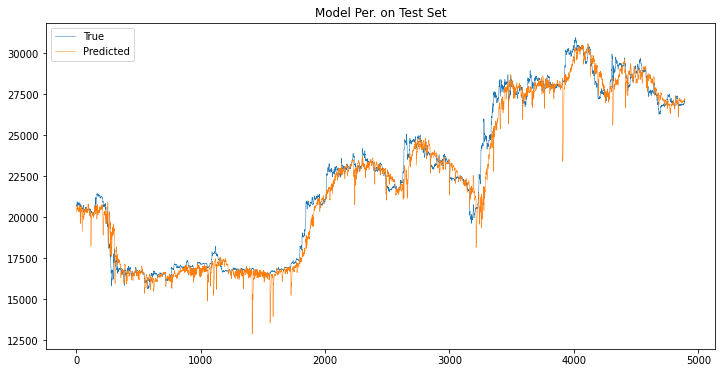

(array([[20318.582],
        [20362.889],
        [20517.781],
        ...,
        [27151.994],
        [27174.625],
        [27284.197]], dtype=float32),
 array([[20746.],
        [20762.],
        [20685.],
        ...,
        [27045.],
        [27077.],
        [27115.]], dtype=float32),
 609738.44,
 513.6207)

In [5]:
args_dict_train = {
            "is_training": 1,
            "train_only": True,
            "model_id": "preformer_btc_96_1_1_top_features",
            "model": "Preformer",
            "data": "custom",
            "root_path": "../../../data/",
            "data_path": "training_data_top_features_for_other_models.csv",
            "features": "MS",
            "target": "close",
            "freq": "h",
            "seq_len": 96,
            "label_len": 1,
            "pred_len": 1,
            "enc_in": 11,
            "dec_in": 11,
            "c_out": 1,
            "d_model": 512,
            "n_heads": 8,
            "e_layers": 2,
            "d_layers": 1,
            "d_ff": 1024,
            "dropout": 0.28,
            "embed": "timeF",
            "activation": "gelu",
            "do_predict": True,
            "train_epochs": 50,
            "batch_size": 64,
            "learning_rate": 0.001,
            "loss": "mse",
            "use_gpu": 1,
            "gpu": 3,
            "train_epochs": 1
        }

model = Train_Tester(**args_dict_train).train()
args_dict_val = {
    "root_path": "../../../data/",
    "data_path": "testing_data_top_features_for_other_models.csv",
    "model_id": "preformer_btc_96_1_1_top_features",
    "model": "Preformer",
    "data": "custom",
    "features": "MS",
    "target": "close",
    "freq": "h",
    "seq_len": 96,
    "label_len": 1,
    "pred_len": 1,
    "enc_in": 11,
    "dec_in": 11,
    "c_out": 1,
    "d_model": 512,
    "n_heads": 8,
    "e_layers": 2,
    "d_layers": 1,
    "d_ff": 1024,
    "dropout": 0.28,
    "embed": "timeF",
    "activation": "gelu",
    "do_predict": True,
    "use_gpu": 1,
    "gpu": 3,
    "batch_size": 1,
}

Train_Tester(**args_dict_val).test(model)


#### Top Columns (Input: last 96 data points, Output: the next 12th future data)

Use GPU: cuda:3
>>>>>>>start training : preformer_btc_96_12_12_top_features_Preformer_custom_ftMS_sl96_ll12_pl12_dm512_nh8_el2_dl1_df1024_fc1_ebtimeF_dtTrue_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 89706
	iters: 100, epoch: 1 | loss: 0.0167852
	speed: 0.5202s/iter; left time: 677.2787s
	iters: 200, epoch: 1 | loss: 0.0105216
	speed: 0.4787s/iter; left time: 575.4167s
	iters: 300, epoch: 1 | loss: 0.0081232
	speed: 0.4917s/iter; left time: 541.8316s
	iters: 400, epoch: 1 | loss: 0.0107293
	speed: 0.5096s/iter; left time: 510.6400s
	iters: 500, epoch: 1 | loss: 0.0075469
	speed: 0.5098s/iter; left time: 459.7989s
	iters: 600, epoch: 1 | loss: 0.0056847
	speed: 0.4902s/iter; left time: 393.1714s
	iters: 700, epoch: 1 | loss: 0.0037382
	speed: 0.4792s/iter; left time: 336.3782s
	iters: 800, epoch: 1 | loss: 0.0032321
	speed: 0.4831s/iter; left time: 290.8080s
	iters: 900, epoch: 1 | loss: 0.0039990
	speed: 0.4959s/iter; left time: 248.9193s
	iters: 1000, epoch: 1 | loss: 0.0041292
	speed: 0.

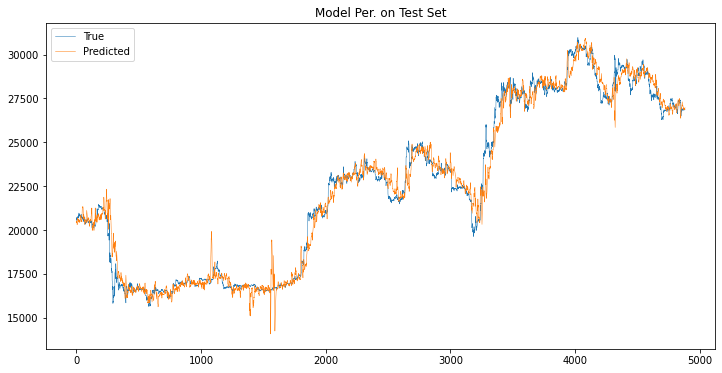

(array([[20424.406],
        [20440.105],
        [20447.896],
        ...,
        [27116.13 ],
        [27137.518],
        [27021.777]], dtype=float32),
 array([[20479.],
        [20712.],
        [20634.],
        ...,
        [26899.],
        [26891.],
        [26905.]], dtype=float32),
 492087.0,
 468.76318)

In [6]:
args_dict_train = {
            "is_training": 1,
            "train_only": True,
            "model_id": "preformer_btc_96_12_12_top_features",
            "model": "Preformer",
            "data": "custom",
            "root_path": "../../../data/",
            "data_path": "training_data_top_features_for_other_models.csv",
            "features": "MS",
            "target": "close",
            "freq": "h",
            "seq_len": 96,
            "label_len": 12,
            "pred_len": 12,
            "enc_in": 11,
            "dec_in": 11,
            "c_out": 1,
            "d_model": 512,
            "n_heads": 8,
            "e_layers": 2,
            "d_layers": 1,
            "d_ff": 1024,
            "dropout": 0.28,
            "embed": "timeF",
            "activation": "gelu",
            "do_predict": True,
            "train_epochs": 50,
            "batch_size": 64,
            "learning_rate": 0.001,
            "loss": "mse",
            "use_gpu": 1,
            "gpu": 3,
            "train_epochs": 1
        }

model = Train_Tester(**args_dict_train).train()
args_dict_val = {
    "root_path": "../../../data/",
    "data_path": "testing_data_top_features_for_other_models.csv",
    "model_id": "preformer_btc_96_12_12_top_features",
    "model": "Preformer",
    "data": "custom",
    "features": "MS",
    "target": "close",
    "freq": "h",
    "seq_len": 96,
    "label_len": 12,
    "pred_len": 12,
    "enc_in": 11,
    "dec_in": 11,
    "c_out": 1,
    "d_model": 512,
    "n_heads": 8,
    "e_layers": 2,
    "d_layers": 1,
    "d_ff": 1024,
    "dropout": 0.28,
    "embed": "timeF",
    "activation": "gelu",
    "do_predict": True,
    "use_gpu": 1,
    "gpu": 3,
    "batch_size": 1,
}

Train_Tester(**args_dict_val).test(model)


#### Top Columns (Input: last 504 data points, Output: the next 12th future data)

In [7]:
args_dict_train = {
            "is_training": 1,
            "train_only": True,
            "model_id": "preformer_btc_504_12_12_top_features",
            "model": "Preformer",
            "data": "custom",
            "root_path": "../../../data/",
            "data_path": "training_data_top_features_for_other_models.csv",
            "features": "MS",
            "target": "close",
            "freq": "h",
            "seq_len": 504,
            "label_len": 12,
            "pred_len": 12,
            "enc_in": 11,
            "dec_in": 11,
            "c_out": 1,
            "d_model": 512,
            "n_heads": 8,
            "e_layers": 2,
            "d_layers": 1,
            "d_ff": 1024,
            "dropout": 0.28,
            "embed": "timeF",
            "activation": "gelu",
            "do_predict": True,
            "train_epochs": 50,
            "batch_size": 64,
            "learning_rate": 0.001,
            "loss": "mse",
            "use_gpu": 1,
            "gpu": 3,
            "train_epochs": 1
        }

model = Train_Tester(**args_dict_train).train()
args_dict_val = {
    "root_path": "../../../data/",
    "data_path": "testing_data_top_features_for_other_models.csv",
    "model_id": "preformer_btc_504_12_12_top_features",
    "model": "Preformer",
    "data": "custom",
    "features": "MS",
    "target": "close",
    "freq": "h",
    "seq_len": 504,
    "label_len": 12,
    "pred_len": 12,
    "enc_in": 11,
    "dec_in": 11,
    "c_out": 1,
    "d_model": 512,
    "n_heads": 8,
    "e_layers": 2,
    "d_layers": 1,
    "d_ff": 1024,
    "dropout": 0.28,
    "embed": "timeF",
    "activation": "gelu",
    "do_predict": True,
    "use_gpu": 1,
    "gpu": 3,
    "batch_size": 1,
}

Train_Tester(**args_dict_val).test(model)


Use GPU: cuda:3
>>>>>>>start training : preformer_btc_504_12_12_top_features_Preformer_custom_ftMS_sl504_ll12_pl12_dm512_nh8_el2_dl1_df1024_fc1_ebtimeF_dtTrue_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 89298


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 3; 7.79 GiB total capacity; 6.25 GiB already allocated; 34.50 MiB free; 6.68 GiB reserved in total by PyTorch)

# --------------------------